# GRF - examples 3D

Generate gaussian random fields (GRF) using fast Fourier transform (FFT).

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

# import from package 'geone'
import geone.covModel as gcm
import geone.grf as grf
import geone.img as img
#import geone.imgplot as imgplt
import geone.imgplot3d as imgplt3
#import geone.customcolors as ccol

## Define a covariance model in 3D: class `covModel3D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles can be specified in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:
    - Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
    - Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
    - Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''

In [2]:
cov_model = gcm.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[40, 20, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                      # elementary contribution
    ], alpha=-30, beta=-40, gamma=20, name='model-3D example')

In [3]:
cov_model

Covariance model 3D: (Name = model-3D example)
   2 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 8.5,  r = [40, 20, 10]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angles: alpha = -30 deg., beta = -40 deg., gamma = 20 deg.
   i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
         is obtained from the system Oxyz as follows:
         Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
         Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
         Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''

### Plot the covariance / variogram function of the model

Plot the covariance function by using the method `plot_model3d_volume` of the class for a 3D volume representation (based on `pyvista` module). The main axes are shown in red (x'''), green (y''') and blue (z''''), or in custom colors passing the keyword arguments `color0` (x'''),  `color1` (y'''), and `color2` (z''').

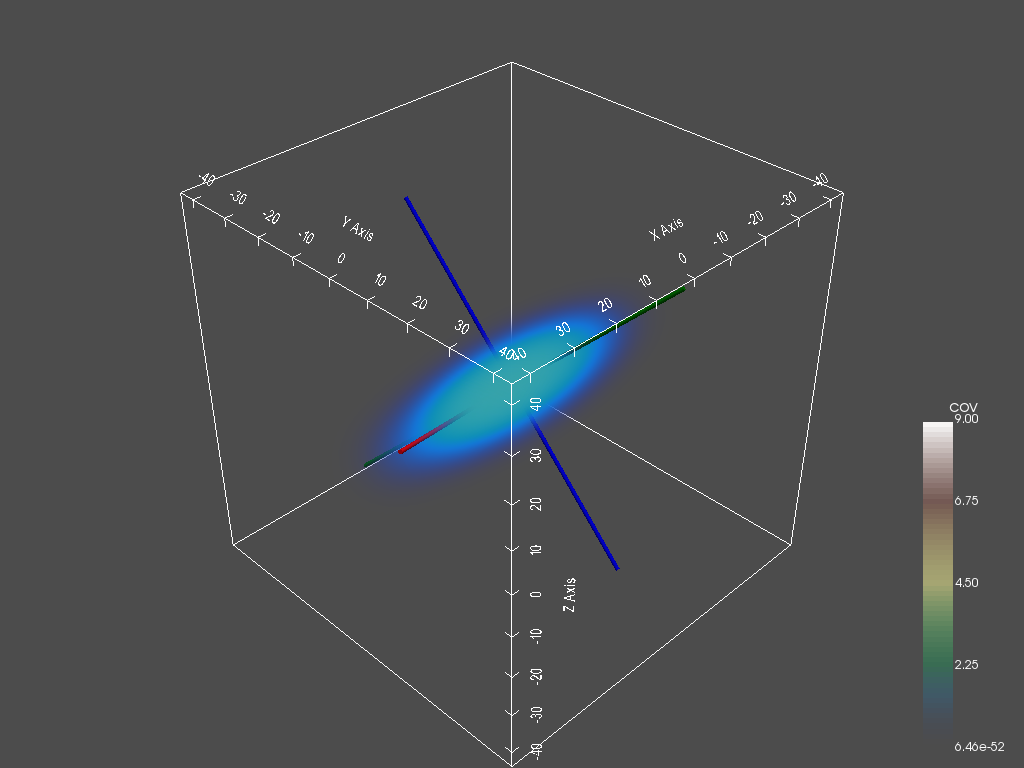

In [4]:
cov_model.plot_model3d_volume()

For a view in an intaractive figure (pop-up window), uncomment the lines in the following cell and run it.

In [5]:
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model.plot_model3d_volume(plotter=pp)
#pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

The method `plot_model3d_slice` of the class gives a 3D representations with slices orthogonal to the main axes and going through the origin (by default). 

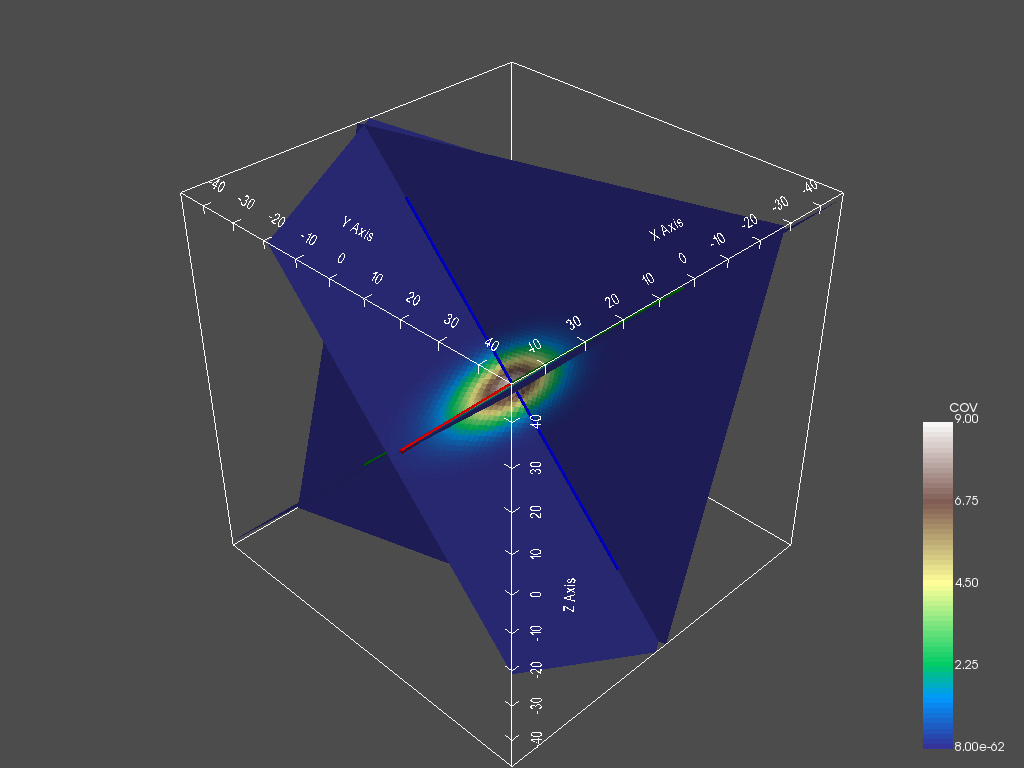

In [6]:
cov_model.plot_model3d_slice()

In [7]:
## Interactive figure
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model.plot_model3d_slice(plotter=pp)
#pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

For plotting slices orthogonal to each axis of the system Oxyz:

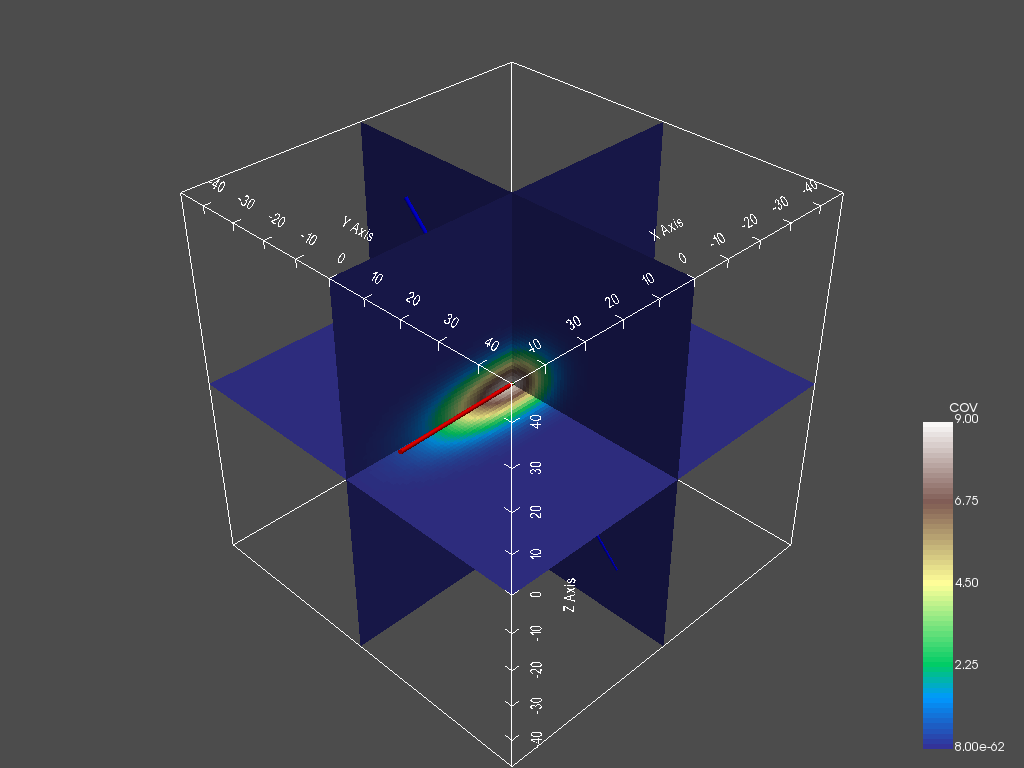

In [8]:
cov_model.plot_model3d_slice(slice_normal_x=0, slice_normal_y=0, slice_normal_z=0, slice_normal_custom=None)

In [9]:
## Interactive figure
#pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
#cov_model.plot_model3d_slice(plotter=pp, 
#                             slice_normal_x=0, slice_normal_y=0, slice_normal_z=0, slice_normal_custom=None)
#pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

Plot the covariance function by using the method `plot_model_curves` of the class for plotting the function along each main axis (x''', y''', and z'''). Again, the default colors can be changed by passing the keyword arguments `color0`,  `color1`, and `color2`.

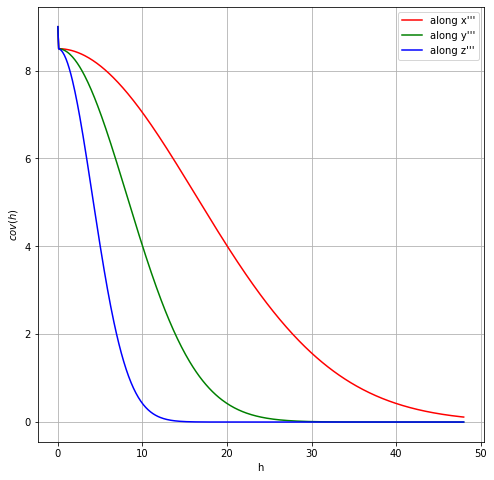

In [10]:
plt.figure(figsize=(8,8))
cov_model.plot_model_curves()
plt.show()

Plotting the variogram function: as above, but passing the keyword argument `vario=True` to the method `plot_model3d_volume` or `plot_model3d_sclice` or `plot_model_curves`.

The main axes (x''', y''' and z''') can be plotted using the method `plot_mrot`. Again, the default colors can be changed by passing the keyword arguments `color0`,  `color1`, and `color2`.

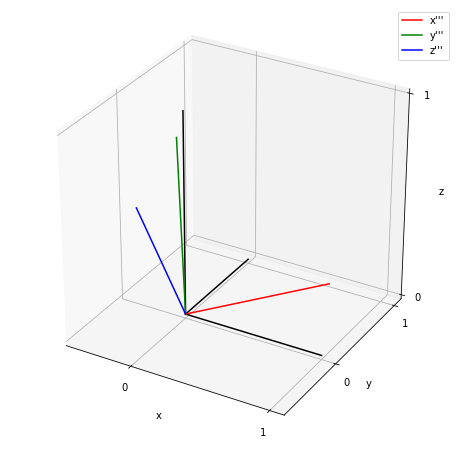

In [11]:
cov_model.plot_mrot(figsize=(8,8))

### Get the sill and ranges

Get the sill and the range along each axis in the coordinates system supporting the axes of the model.

In [12]:
w = cov_model.sill() # scalar
r = cov_model.r123() # vector (1d-array) of length 3 ranges along x'''', y''', z'''
print("Sill = {}".format(w))
print("Range along x''' = {}, along y''' = {}, along z''' = {}".format(r[0], r[1], r[2]))

Sill = 9.0
Range along x''' = 40.0, along y''' = 20.0, along z''' = 10.0


Get the maximal range along each axis of the original system Oxyz.

In [13]:
rxyz = cov_model.rxyz()  # vector (1d-array) of length 2: "max ranges" along x, y, z
print("Max. range along x = {}, along y = {}, along z = {}".format(rxyz[0], rxyz[1], rxyz[2]))

Max. range along x = 36.948833461834035, along y = 13.268278963378767, along z = 12.855752193730785


## Simulation of GRFs - 3D
Define the simulation grid.

In [14]:
nx, ny, nz = 85, 56, 34  # number of cells
dx, dy, dz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = [nx, ny, nz]
spacing = [dx, dy, dz]
origin = [ox, oy, oz]

### Remark
As the generation of GRFs is based on FFT, periodic fields are generated. Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `grf3D` based on the covariance model class passed as first argument. However, the minimal extension along each axis (x, y, and z) can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (in the example below, the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` for each axis (i.e. `[grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxyz(), (nx, ny, nz), (dx, dy, dz))]`), and then passed to the GRF simulator `grf3D` via the keyword argument `extensionMin`.

#### Notes
When passing the covariance model class as first argument, the extension is computed based on the ranges of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the ranges will be multiplied by this factor before computing the extension.

### Unconditional simulations
Set the number of realizations, the seed and launch the (unconditional) simulations.

*Remark:* the keyword argument `printInfo` (`True` by default) can be set to `False` to not display information when running.

In [15]:
nreal = 200
np.random.seed(123)
# sim3Da = grf.grf3D(cov_model, dimension, spacing, origin, nreal=nreal)
sim3Da = grf.grf3D(cov_model, dimension, spacing, origin, nreal=nreal, printInfo=False)

The result is a 4d array of size `nreal` by `nz` by `ny` by `nx`:

In [16]:
sim3Da.shape

(200, 34, 56, 85)

Fill an image (`Img` class) with all realizations (for display, see below), and delete the array sim3Da.

In [17]:
im3a = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim3Da)
del(sim3Da)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [18]:
im3a_mean = img.imageContStat(im3a, op='mean') # pixel-wise mean
im3a_std = img.imageContStat(im3a, op='std')   # pixel-wise standard deviation
# # Or:
# sim3Da_mean = np.mean(sim3Da.reshape(nreal, -1), axis=0).reshape(nz, ny, nx)
# sim3Da_std = np.std(sim3Da.reshape(nreal, -1), axis=0).reshape(nz, ny, nx)
# # and then fill new image with results

Plot the first realizations, the mean, and the standard deviation (in an *interactive figure* or *inline*).

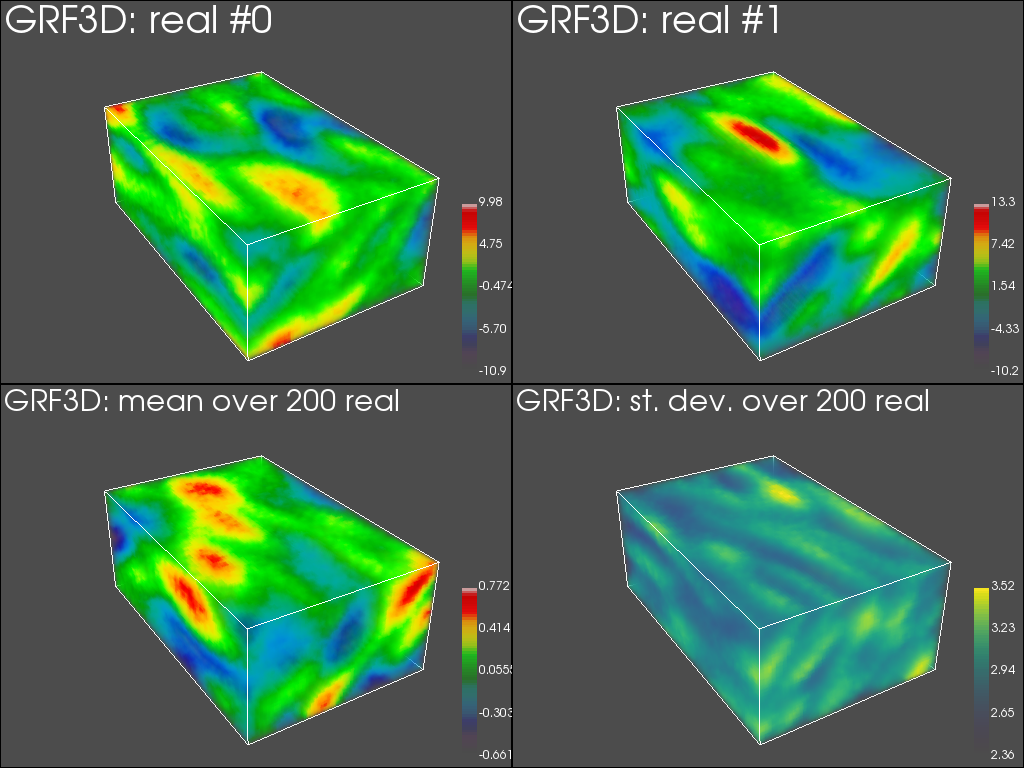

In [19]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_volume(im3a, iv=i, plotter=pp,
                               text='GRF3D: real #{}'.format(i),
                               cmap='nipy_spectral',
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
# mean of all real
pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im3a_mean, plotter=pp,
                           text='GRF3D: mean over {} real'.format(nreal),
                           cmap='nipy_spectral',
                           scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im3a_std, plotter=pp,
                           text='GRF3D: st. dev. over {} real'.format(nreal),
                           cmap='viridis',
                           scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Conditional simulations
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [20]:
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

Launch the simulations and plot.

In [21]:
nreal = 200
np.random.seed(123)
sim3Db = grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im3b = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim3Db)
del(sim3Db)
im3b_mean = img.imageContStat(im3b, op='mean') # pixel-wise mean
im3b_std = img.imageContStat(im3b, op='std')   # pixel-wise standard deviation

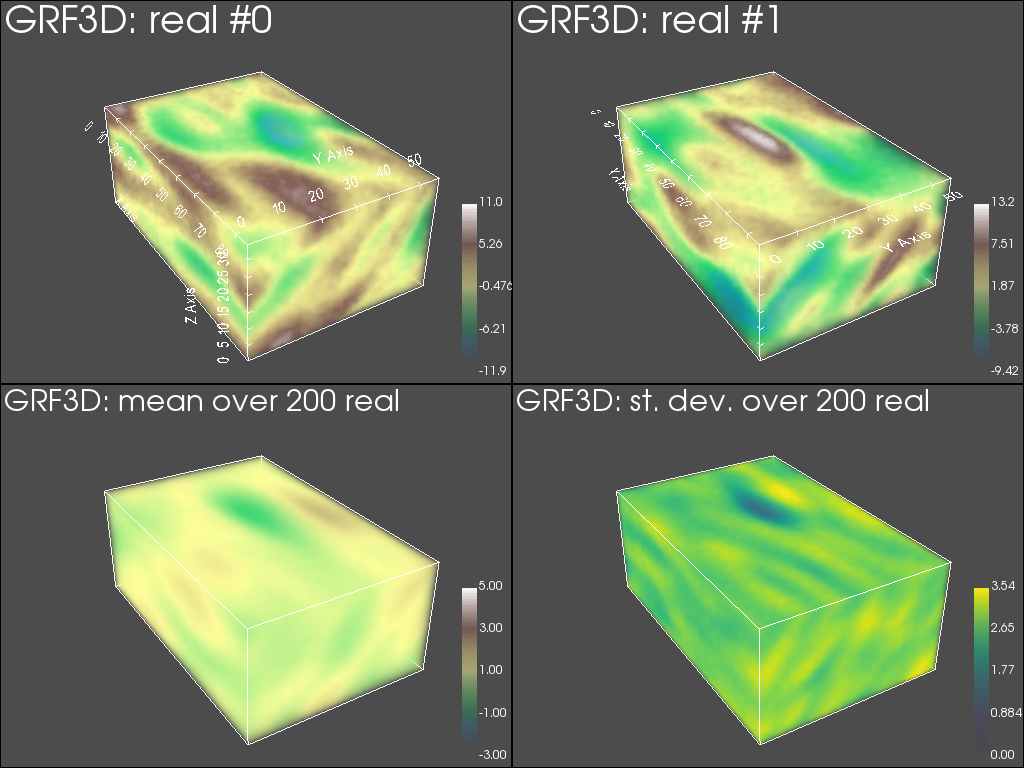

In [22]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_volume(im3b, iv=i, plotter=pp,
                               show_bounds=True, # show axes and ticks around the 3D box
                               text='GRF3D: real #{}'.format(i),
                               cmap='terrain', 
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# mean of all real
pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im3b_mean, plotter=pp,
                           text='GRF3D: mean over {} real'.format(nreal),
                           cmap='terrain', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im3b_std, plotter=pp,
                           text='GRF3D: st. dev. over {} real'.format(nreal),
                           cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

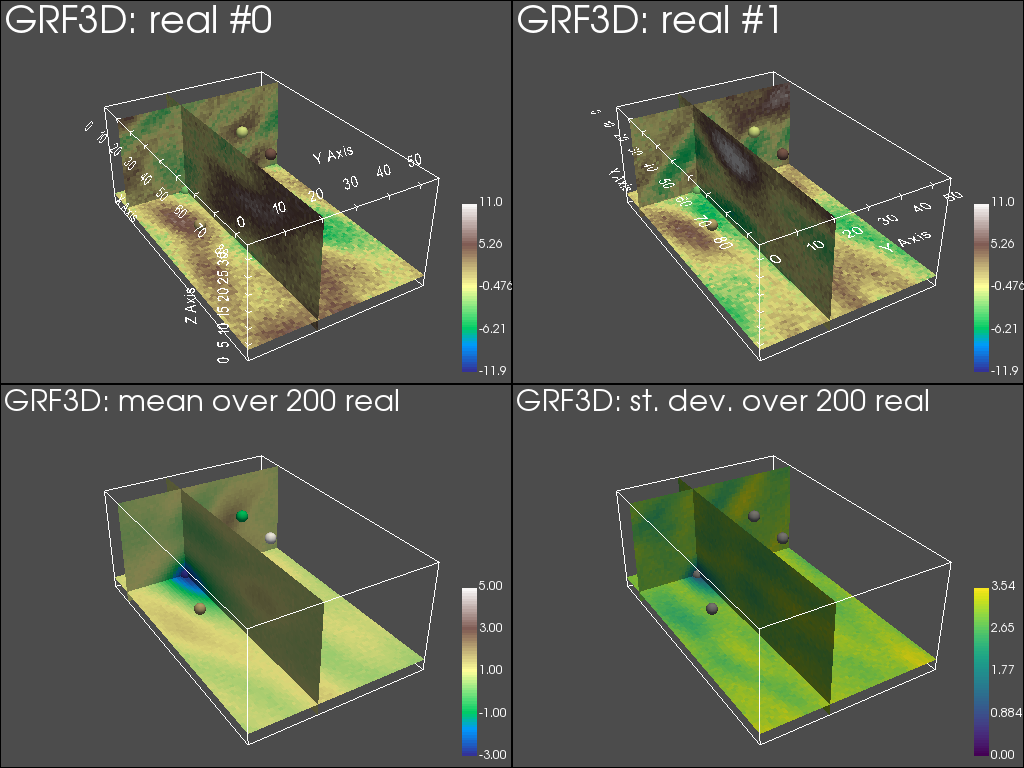

In [23]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
# data points to be added to 3D plot of real
data_points = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = np.min(im3b.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(im3b.vmax()[0:1]) # max value for real 0 and 1
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col
# ... plot
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_slice(im3b, iv=i, plotter=pp,
                              slice_normal_x=x[0,0],
                              slice_normal_y=x[0,1],
                              slice_normal_z=x[0,2],
                              show_bounds=True, # show axes and ticks around the 3D box
                              text='GRF3D: real #{}'.format(i),
                              cmap=cmap, cmin=cmin, cmax=cmax, 
                              scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)


# mean of all real
# data points to be added to 3D plot of mean
data_points_mean = pv.PolyData(x)
# ... set color for data points according to their value (plot of mean)
cmap = plt.get_cmap('terrain') # color map
cmin = im3b_mean.vmin()[0] # min value for mean
cmax = im3b_mean.vmax()[0] # max value for mean
data_points_mean_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_mean['colors'] = data_points_mean_col
# ... plot
pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im3b_mean, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: mean over {} real'.format(nreal),
                          cmap=cmap, cmin=cmin, cmax=cmax, 
                          scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)


# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im3b_std, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: st. dev. over {} real'.format(nreal),
                          cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Kriging
Compute (simple) kriging estimates and standard deviation.

In [24]:
krig3Db, krig3Db_std = grf.krige3D(x, v, cov_model, dimension, spacing, origin)

KRIGE3D: Computing circulant embedding...
KRIGE3D: Embedding dimension: 128 x 128 x 64
KRIGE3D: Computing FFT of circulant matrix...
KRIGE3D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE3D: Computing rBA * rAA^(-1)...
KRIGE3D: computing kriging estimates...
KRIGE3D: computing kriging standard deviation ...


Fill an image (Img class) with kriging estimates and standard deviation (for display, see below), and delete array krig3Db and krig3Db_std.

In [25]:
im3b_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((krig3Db, krig3Db_std)))
del(krig3Db, krig3Db_std)

Plot the kriging estimates and standard deviation.

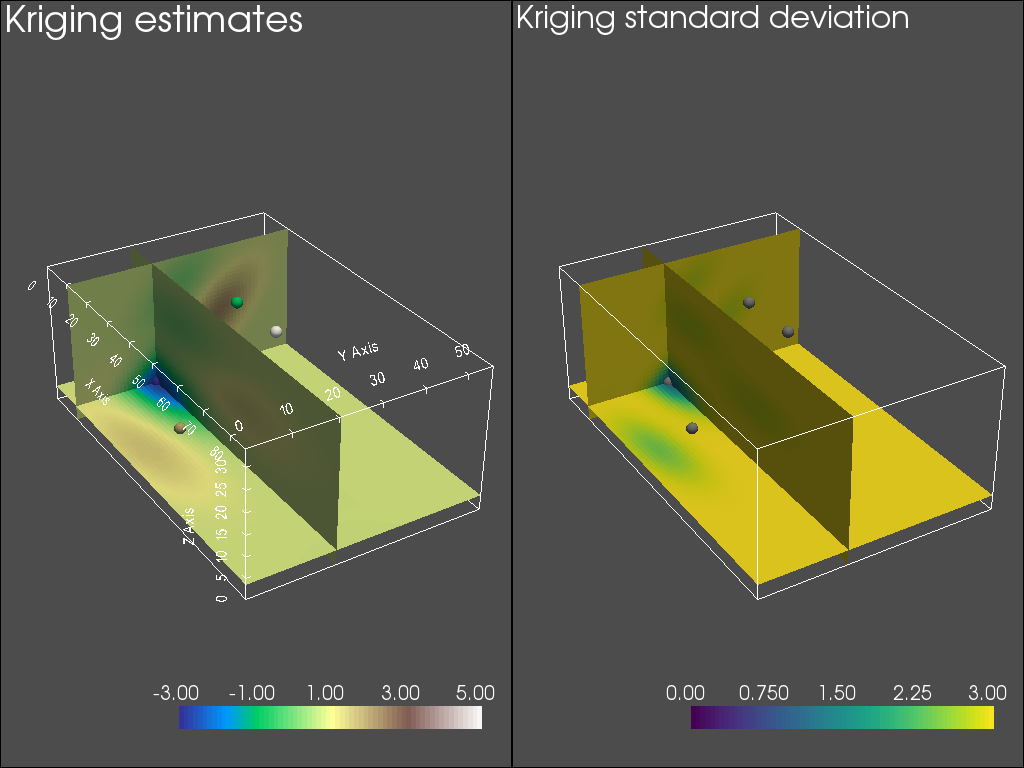

In [26]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

# data points to be added to 3D plot
data_points_krig = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = im3b_krig.vmin()[0] # min value for krig. est.
cmax = im3b_krig.vmax()[0] # max value for krig. est.
data_points_krig_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_krig['colors'] = data_points_krig_col

# kriging estimates
pp.subplot(0, 0)
imgplt3.drawImage3D_slice(im3b_krig, iv=0, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Kriging estimates',
                          cmap=cmap, cmin=cmin, cmax=cmax, scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging standard deviation
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im3b_krig, iv=1, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='Kriging standard deviation',
                          cmap='viridis', scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Comparison of mean and standard deviation of all realizations with kriging results

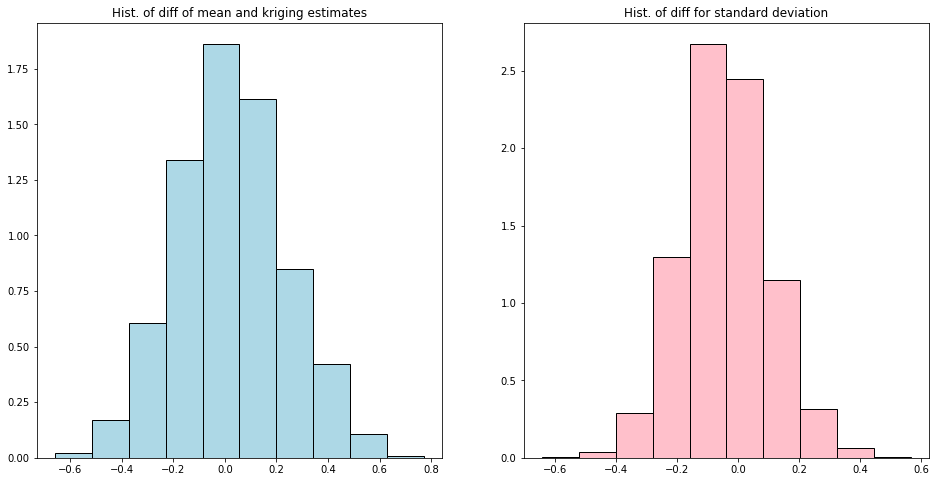

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im3b_mean.val.reshape(-1) - im3b_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im3b_std.val.reshape(-1) - im3b_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Simulations with imposed mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).

### Simulations with constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill.

In [28]:
nreal = 200
np.random.seed(123)
sim3Dc = grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, mean=3., var=2*cov_model.sill(), nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im3c = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim3Dc)
del(sim3Dc)
im3c_mean = img.imageContStat(im3c, op='mean') # pixel-wise mean
im3c_std = img.imageContStat(im3c, op='std')   # pixel-wise standard deviation

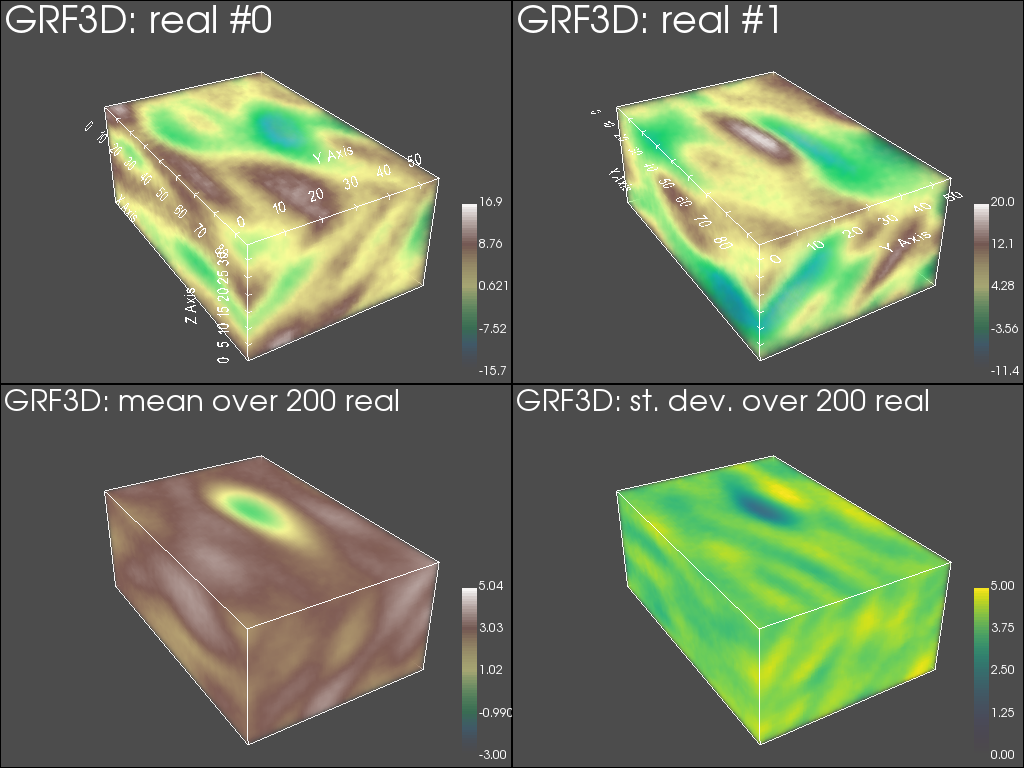

In [29]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_volume(im3c, iv=i, plotter=pp,
                               show_bounds=True, # show axes and ticks around the 3D box
                               text='GRF3D: real #{}'.format(i),
                               cmap='terrain', 
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# mean of all real
pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im3c_mean, plotter=pp,
                           text='GRF3D: mean over {} real'.format(nreal),
                           cmap='terrain', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im3c_std, plotter=pp,
                           text='GRF3D: st. dev. over {} real'.format(nreal),
                           cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

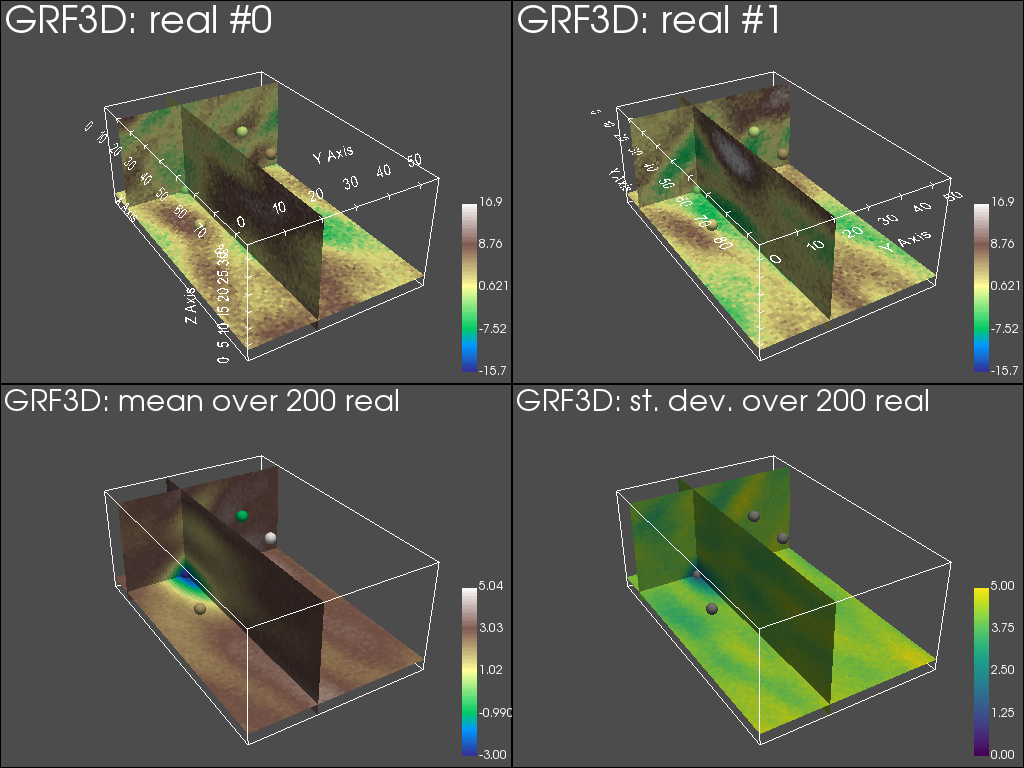

In [30]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
# data points to be added to 3D plot of real
data_points = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = np.min(im3c.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(im3c.vmax()[0:1]) # max value for real 0 and 1
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col
# ... plot
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_slice(im3c, iv=i, plotter=pp,
                              slice_normal_x=x[0,0],
                              slice_normal_y=x[0,1],
                              slice_normal_z=x[0,2],
                              show_bounds=True, # show axes and ticks around the 3D box
                              text='GRF3D: real #{}'.format(i),
                              cmap=cmap, cmin=cmin, cmax=cmax,
                              scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)


# mean of all real
# data points to be added to 3D plot of mean
data_points_mean = pv.PolyData(x)
# ... set color for data points according to their value (plot of mean)
cmap = plt.get_cmap('terrain') # color map
cmin = im3c_mean.vmin()[0] # min value for mean
cmax = im3c_mean.vmax()[0] # max value for mean
data_points_mean_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_mean['colors'] = data_points_mean_col
# ... plot
pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im3c_mean, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: mean over {} real'.format(nreal),
                          cmap=cmap, cmin=cmin, cmax=cmax,
                          scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)


# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im3c_std, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: st. dev. over {} real'.format(nreal),
                          cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [31]:
krig3Dc, krig3Dc_std = grf.krige3D(x, v, cov_model, dimension, spacing, origin, mean=3., var=2*cov_model.sill())

# Fill image with result
im3c_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((krig3Dc, krig3Dc_std)))
del(krig3Dc, krig3Dc_std)

KRIGE3D: Computing circulant embedding...
KRIGE3D: Embedding dimension: 128 x 128 x 64
KRIGE3D: Computing FFT of circulant matrix...
KRIGE3D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE3D: Computing rBA * rAA^(-1)...
KRIGE3D: computing kriging estimates...
KRIGE3D: computing kriging standard deviation ...


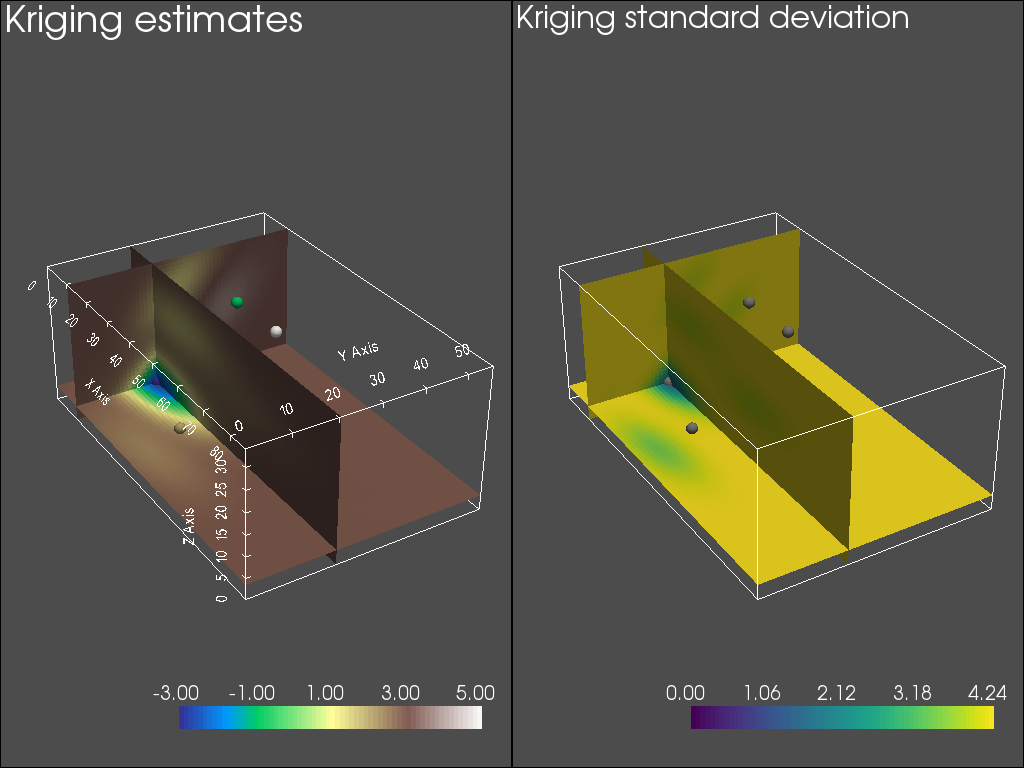

In [32]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

# data points to be added to 3D plot
data_points_krig = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = im3c_krig.vmin()[0] # min value for krig. est.
cmax = im3c_krig.vmax()[0] # max value for krig. est.
data_points_krig_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_krig['colors'] = data_points_krig_col

# kriging estimates
pp.subplot(0, 0)
imgplt3.drawImage3D_slice(im3c_krig, iv=0, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Kriging estimates',
                          cmap=cmap, cmin=cmin, cmax=cmax, scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging standard deviation
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im3c_krig, iv=1, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='Kriging standard deviation',
                          cmap='viridis', scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

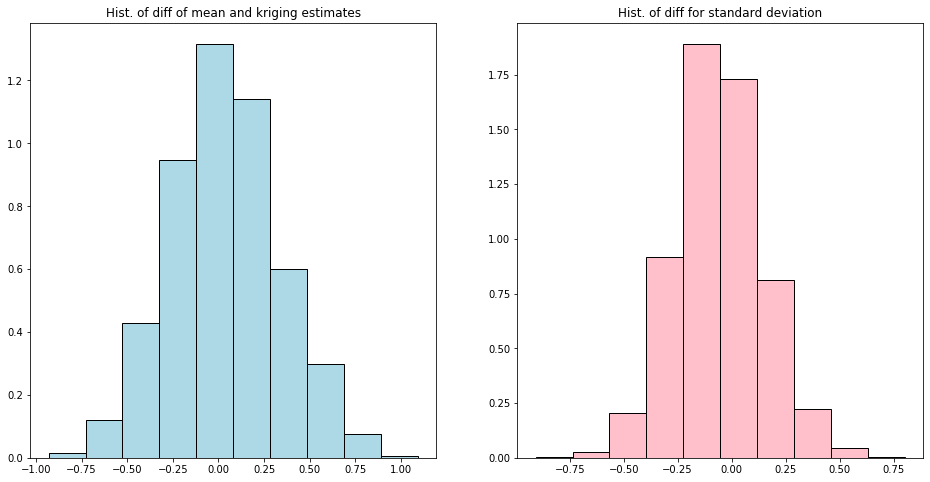

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im3c_mean.val.reshape(-1) - im3c_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im3c_std.val.reshape(-1) - im3c_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

### Simulations with non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [34]:
# Coordinates of the center of grid cells
xg = ox + dx*(0.5+np.arange(nx))
yg = oy + dy*(0.5+np.arange(ny))
zg = oz + dz*(0.5+np.arange(nz))

# Create a meshgrid from the center of grid cells
zz, yy, xx = np.meshgrid(zg, yg, xg, indexing='ij')

# Define the mean and variance on the simulation grid
mean = 0.1*(zz + yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy + zz)      # define variance on the simulation grid

# Fill image for display
im = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((mean, var)))

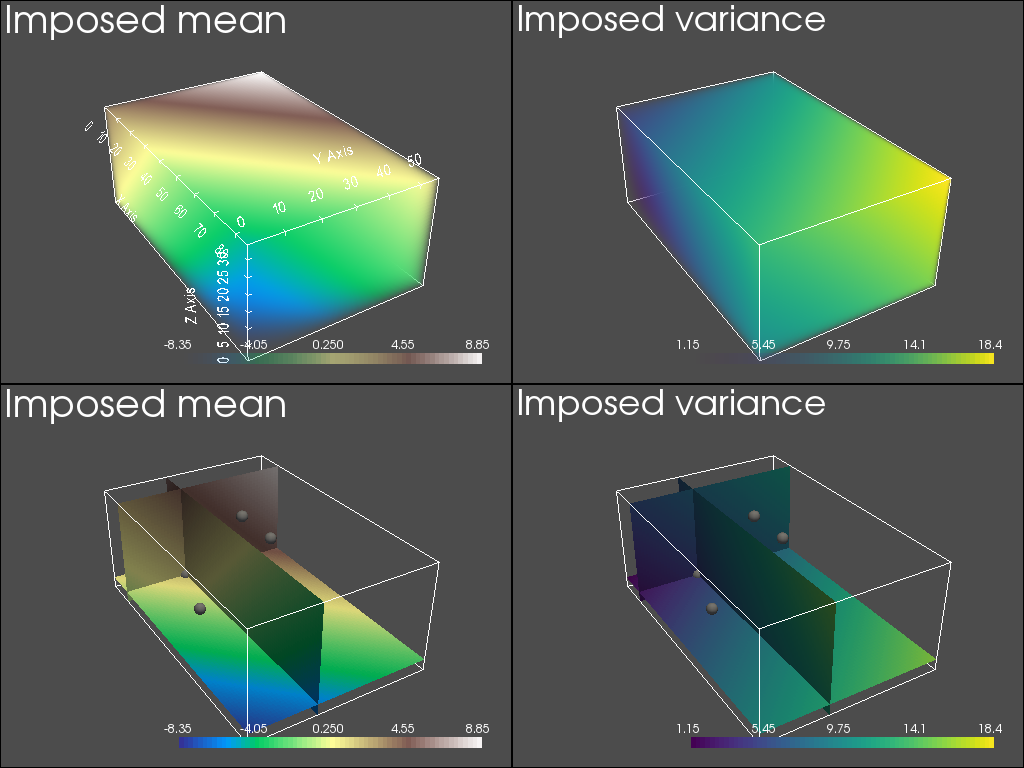

In [35]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# data points to be added to plot
data_points = pv.PolyData(x)

# mean (3d)
pp.subplot(0, 0)
imgplt3.drawImage3D_volume(im, iv=0, plotter=pp,
                           show_bounds=True, # show axes and ticks around the 3D box
                           text='Imposed mean',
                           cmap='terrain', scalar_bar_kwargs={'title':None, 'label_font_size':12})

# var
pp.subplot(0, 1)
imgplt3.drawImage3D_volume(im, iv=1, plotter=pp,
                           text='Imposed variance',
                           cmap='viridis', scalar_bar_kwargs={'title':None, 'label_font_size':12})

# mean
pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im, iv=0, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='Imposed mean',
                          cmap='terrain', scalar_bar_kwargs={'title':None, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)


# var
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im, iv=1, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='Imposed variance',
                          cmap='viridis', scalar_bar_kwargs={'title':None, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [36]:
nreal = 200
np.random.seed(123)
sim3Dd = grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, mean=mean, var=var, nreal=nreal, printInfo=False)

# Fill image with result, and compute statistics
im3d = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=nreal, val=sim3Dd)
del(sim3Dd)
im3d_mean = img.imageContStat(im3d, op='mean') # pixel-wise mean
im3d_std = img.imageContStat(im3d, op='std')   # pixel-wise standard deviation

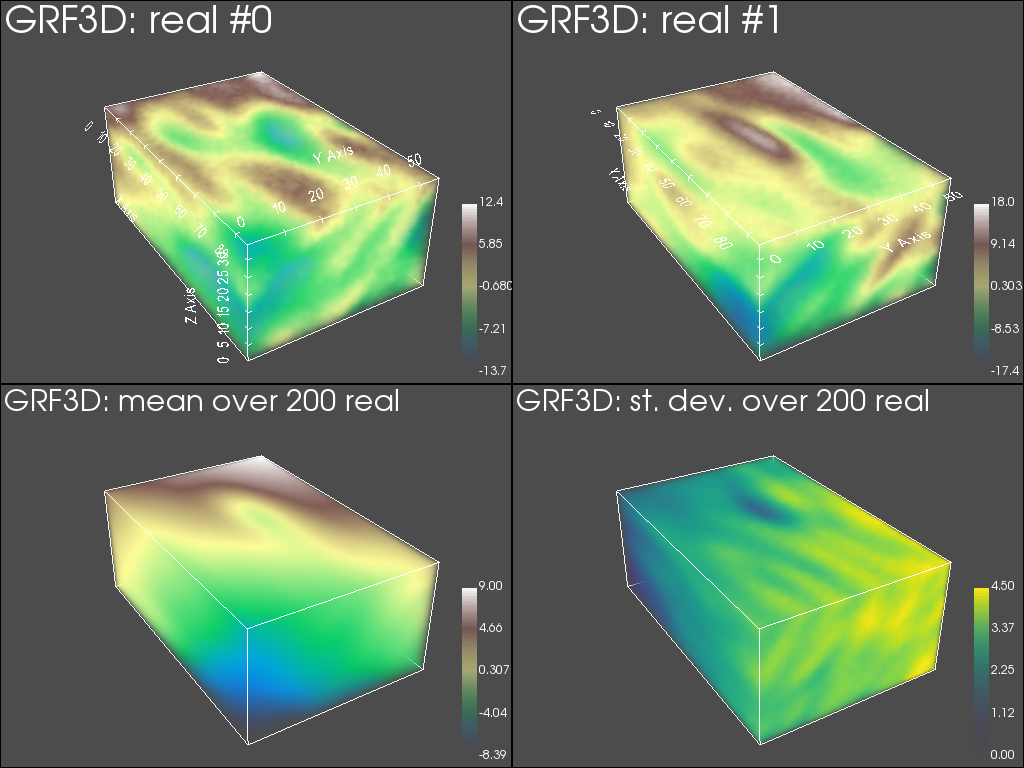

In [37]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_volume(im3d, iv=i, plotter=pp,
                               show_bounds=True, # show axes and ticks around the 3D box
                               text='GRF3D: real #{}'.format(i),
                               cmap='terrain', 
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# mean of all real
pp.subplot(1, 0)
imgplt3.drawImage3D_volume(im3d_mean, plotter=pp,
                           text='GRF3D: mean over {} real'.format(nreal),
                           cmap='terrain', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})

# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_volume(im3d_std, plotter=pp,
                           text='GRF3D: st. dev. over {} real'.format(nreal),
                           cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

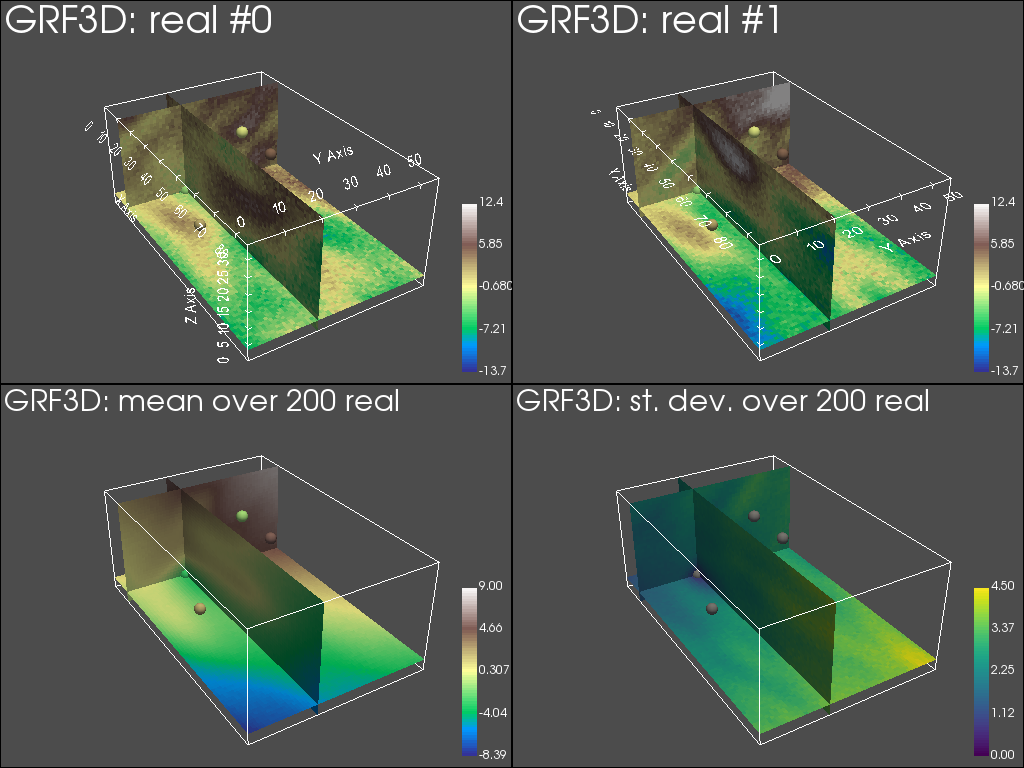

In [38]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
# data points to be added to 3D plot of real
data_points = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = np.min(im3d.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(im3d.vmax()[0:1]) # max value for real 0 and 1
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col
# ... plot
for i in (0, 1):
    pp.subplot(0, i)
    imgplt3.drawImage3D_slice(im3d, iv=i, plotter=pp,
                              slice_normal_x=x[0,0],
                              slice_normal_y=x[0,1],
                              slice_normal_z=x[0,2],
                              show_bounds=True, # show axes and ticks around the 3D box
                              text='GRF3D: real #{}'.format(i),
                              cmap=cmap, cmin=cmin, cmax=cmax,
                              scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)


# mean of all real
# data points to be added to 3D plot of mean
data_points_mean = pv.PolyData(x)
# ... set color for data points according to their value (plot of mean)
cmap = plt.get_cmap('terrain') # color map
cmin = im3d_mean.vmin()[0] # min value for mean
cmax = im3d_mean.vmax()[0] # max value for mean
data_points_mean_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_mean['colors'] = data_points_mean_col
# ... plot
pp.subplot(1, 0)
imgplt3.drawImage3D_slice(im3d_mean, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: mean over {} real'.format(nreal),
                          cmap=cmap, cmin=cmin, cmax=cmax,
                          scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)


# standard deviation of all real
pp.subplot(1, 1)
imgplt3.drawImage3D_slice(im3d_std, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='GRF3D: st. dev. over {} real'.format(nreal),
                          cmap='viridis', scalar_bar_kwargs={'vertical':True, 'label_font_size':12, 'title':None})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [39]:
krig3Dd, krig3Dd_std = grf.krige3D(x, v, cov_model, dimension, spacing, origin, mean=mean, var=var)

# Fill image with result
im3d_krig = img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=2, val=np.array((krig3Dd, krig3Dd_std)))
del(krig3Dd, krig3Dd_std)

KRIGE3D: Computing circulant embedding...
KRIGE3D: Embedding dimension: 128 x 128 x 64
KRIGE3D: Computing FFT of circulant matrix...
KRIGE3D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE3D: Computing rBA * rAA^(-1)...
KRIGE3D: computing kriging estimates...
KRIGE3D: computing kriging standard deviation ...


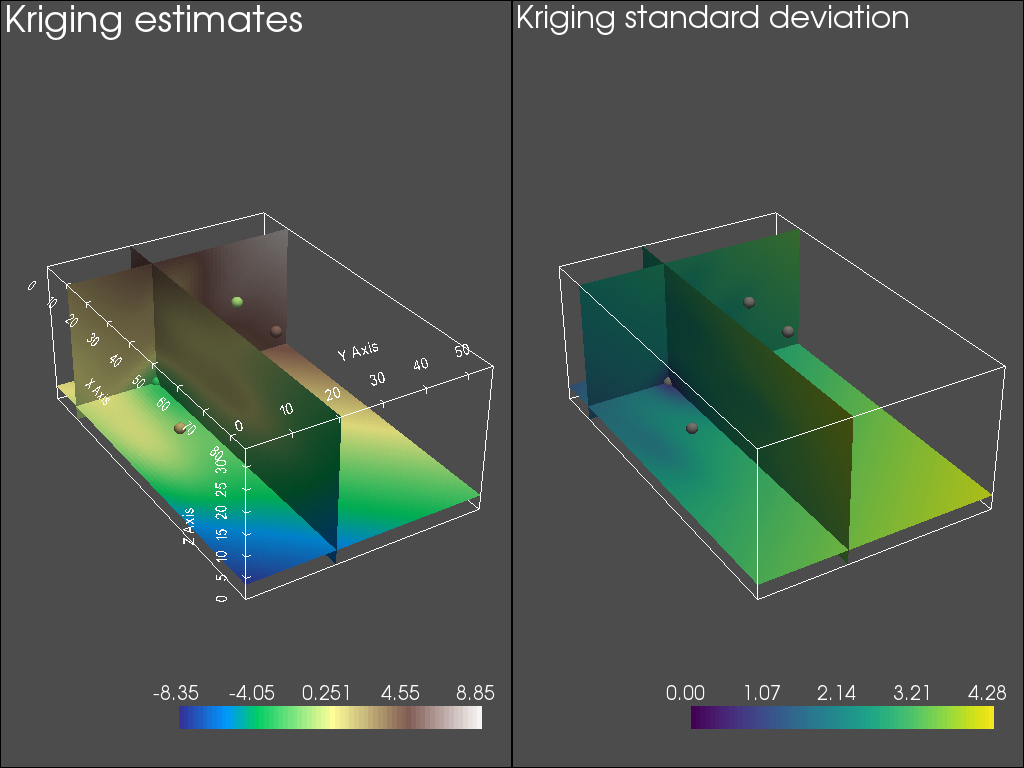

In [40]:
# Plot "interactive" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

# data points to be added to 3D plot
data_points_krig = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = im3d_krig.vmin()[0] # min value for krig. est.
cmax = im3d_krig.vmax()[0] # max value for krig. est.
data_points_krig_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_krig['colors'] = data_points_krig_col

# kriging estimates
pp.subplot(0, 0)
imgplt3.drawImage3D_slice(im3d_krig, iv=0, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          show_bounds=True, # show axes and ticks around the 3D box
                          text='Kriging estimates',
                          cmap=cmap, cmin=cmin, cmax=cmax, scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging standard deviation
pp.subplot(0, 1)
imgplt3.drawImage3D_slice(im3d_krig, iv=1, plotter=pp,
                          slice_normal_x=x[0,0],
                          slice_normal_y=x[0,1],
                          slice_normal_z=x[0,2],
                          text='Kriging standard deviation',
                          cmap='viridis', scalar_bar_kwargs={'title':None, 'label_font_size':20})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

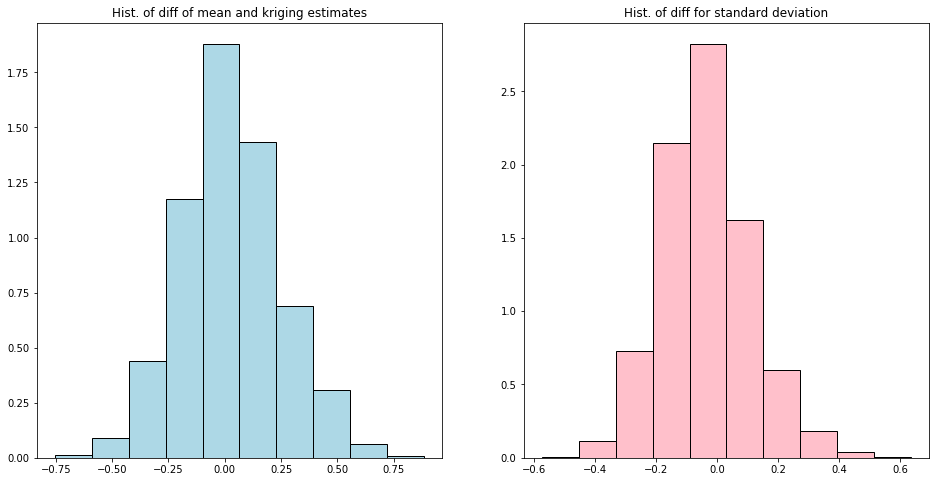

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(im3d_mean.val.reshape(-1) - im3d_krig.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(im3d_std.val.reshape(-1) - im3d_krig.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()